In [1]:
!pip install torchaudio

In [2]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import glob
import os
import pandas as pd
import traceback
import numpy as np
from tqdm import tqdm
import pandas as pd

In [3]:
import librosa
import pandas as pd
import traceback
import os

class MetaCreate():
    def __init__(self, transcription_path:str=r'/home/amon/Downloads/ALFFA_PUBLIC/ASR/SWAHILI/data/train/text', audio_path:str='/home/amon/Downloads/ALFFA_PUBLIC/ASR/SWAHILI/data/train',audio_extension='wav') -> None:
        self.meta=None
        self.transcription_path=transcription_path
        self.audio_path=audio_path
        self.audio_extension=audio_extension
        self.file_to_trancscript={}
        self.file_to_path={}
    def load_transcription(self):
        name_to_text = {}
        try:
            with open (self.transcription_path, encoding="utf-8")as f:
                f.readline()
                for line in f:
                    line=line.strip()
                    ls=line.split("\t",1)
                    name_to_text[ls[0]]=ls[1]
            self.file_to_trancscript=name_to_text
        except FileNotFoundError:
            print(f"File {self.transcription_path} couldn't be found")
        except Exception:
            print("Error Occured")
            traceback.print_exc()
        return name_to_text
    def get_file_to_transcription(self):
        return self.file_to_trancscript

    def load_audio_file_paths(self):
        dict={}
        try:
            files = librosa.util.find_files(self.audio_path, ext=self.audio_extension, recurse=True)
            names = [os.path.splitext(os.path.basename(x))[0] for x in files]
            for i in range(0,len(files)):
                dict[names[i]]=os.path.relpath(files[i])
            self.file_to_path=dict
        except Exception:
            print("Error Occured")
            traceback.print_exc()
        return dict
    def get_file_to_path(self):
        return self.file_to_path
    def meta_data(self): 
        target=[]
        filenames=[]
        paths=[]
        duration_of_recordings=[]
        channels=[]
        sampleRates=[]
        for i in self.file_to_trancscript:
            try:
                target.append(self.file_to_trancscript[i])
                filenames.append(i)
                paths.append(self.file_to_path[i])

                audio, sampleRate = librosa.load(self.file_to_path[i],sr=None,mono=False)
                sampleRates.append(sampleRate)
                duration_of_recordings.append(float(audio.shape[0]/sampleRate))
                channels.append(len(audio.shape))
            except KeyError:
                print(f"Error occured couldn't find path for {i}")
                continue
            except Exception:
                print(f"Error Occured for file {i}")
                traceback.print_exc()
                continue
                
                
        data=pd.DataFrame({'file': filenames,'text': target,'path':paths,'sample_rate':sampleRates,"channels":channels, 'duration':duration_of_recordings})
        self.meta=data
        return data
    def generate_meta_data(self):
        self.load_audio_file_paths()
        self.load_transcription()
        self.meta_data()
        return self.meta
    def get_meta(self):
        return self.meta
    def meta_to_csv(self,path='meta.csv'):
        self.meta.to_csv(path)

In [4]:
meta=MetaCreate()
meta_data=meta.generate_meta_data()

In [5]:
meta_data.head()

,file,text,path,sample_rate,channels,duration
0,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,yanayo andaliwa nami pendo pondo idhaa ya kisw...,../../../../Downloads/ALFFA_PUBLIC/ASR/SWAHILI...,16000,1,3.10
1,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,inayokutangazia moja kwa moja kutoka jijini da...,../../../../Downloads/ALFFA_PUBLIC/ASR/SWAHILI...,16000,1,3.65
2,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,juma hili bara la afrika limeshuhudia raia wa ...,../../../../Downloads/ALFFA_PUBLIC/ASR/SWAHILI...,16000,1,3.90
3,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,wakipiga kura ya maoni ilikufanya mabadiliko ya,../../../../Downloads/ALFFA_PUBLIC/ASR/SWAHILI...,16000,1,2.94
4,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,kule abidjan raia wa jiji hilo,../../../../Downloads/ALFFA_PUBLIC/ASR/SWAHILI...,16000,1,2.45


# Resize and Standardize #

In [6]:
# used to load audio file
#specifying sample rate will resize all the files i.e Audio will be automatically resampled to the given rate
class Loader:
  def __init__(self, sample_rate,duration,mono):
    self.sample_rate=sample_rate
    self.duration=duration
    self.mono=mono
    self.channel = 2


  def load(self,filepath):
    sig, sr = torchaudio.load(filepath)
    aud = sig, sr
    return aud

  #before using this function kindly change your file paths for it to work


  def rechannel(self, aud):    #convert mono to stereo
    # aud=self.aud
    sig, sr = aud
  

    if (sig.shape[0] == self.channel):
      # Nothing to do
      return self.aud

    if (self.channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    aud = resig, sr
  def resample(self,aud):                    #standardize sample rate
    sig, sr = aud
    
    if (sr == self.sample_rate):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, self.sample_rate)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, self.sample_rate)(sig[1:,:])
      resig = torch.cat([resig, retwo])
      aud = resig, self.sample_rate
    return aud

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  def pad_trunc(self,aud):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * self.duration

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      aud = sig, sr
    return aud

In [7]:
class PreprocessingPipeline:
  '''Processes audio files in a directory by applying the following steps
    1. Load the data, convert to stereo and resample sampling rate
    2. Pad the audio
  '''
  def __init__(self):
    self.padder=None
    self._loader=None
   

  def process(self,audio_files_directory):
    for root, directories, files in os.walk(audio_files_directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            self._process_file(filepath)
            print(f"Processed file {filepath}")
    
  def _process_file(self,filepath):
    signal=self.loader.load(filepath)
    signal = self.loader.make_stereo(signal)
    signal = self.loader.resample(signal)
    signal= self.loader.pad_trunc(signal)


In [8]:
DURATION=4000
SAMPLE_RATE=44100
MONO=False

In [9]:
loader=Loader(SAMPLE_RATE, DURATION, MONO)

In [10]:
preprocessing_pipeline=PreprocessingPipeline()
preprocessing_pipeline.loader=loader

In [11]:
Path_to_train = '../home/amon/Downloads/ALFFA_PUBLIC/ASR/SWAHILI/data/train'
preprocessing_pipeline.process(Path_to_train)

# Conversion of mono files to stereo files #

In [12]:
#before using this function kindly change your file paths for it to work


def make_stereo(audio_path):
    #this function converts mono audio channels into stereo channels 
#     logging.info(" ============ Conerting audio sample from mono to stereo ================= ")
    print("======= Mono to stereo audio conversion")
    ifile = wave.open(audio_path)
    #log the info on adio files
#     logging.info(ifile.getparams())
    print (ifile.getparams())
    # (1, 2, 44100, 2013900, 'NONE', 'not compressed')
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = ifile.getparams()
    assert (comptype == 'NONE')  # Compressed not supported yet
    array_type = {1:'B', 2: 'h', 4: 'l'}[sampwidth]
    print(" ======= Calculting left channel type =====")
    left_channel = array.array(array_type, ifile.readframes(nframes))[::nchannels]
    ifile.close()

    #convert the number of channels to 2
    print("====== converting channels ======= ")
    stereo = 2 * left_channel
    stereo[0::2] = stereo[1::2] = left_channel
    #overwrite the wav file making it a stereo file
    print("====== overwriting wav file ======= ")
    ofile = wave.open(audio_path, 'w')
    ofile.setparams((2, sampwidth, framerate, nframes, comptype, compname))
    ofile.writeframes(stereo.tostring())
    ofile.close()

In [13]:
data['key']=data['key'].apply(lambda x: make_stereo(x))

NameError: name 'data' is not defined

# Augmentation #

In [14]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
from numpy import random

In [16]:

train_audio_path = '/home/amon/Downloads/ALFFA_PUBLIC/ASR/SWAHILI/data/train/wav/'
samples, sample_rate = librosa.load(train_audio_path+'SWH-05-20101106/SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part10.wav')
print(samples)
print(sample_rate)

[0.02953335 0.03225018 0.02603412 ... 0.09593043 0.09478676 0.05775513]
22050


In [17]:
x = random.randint(100)
def plot_spec(data:np.array,sr:int) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''
  
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].title.set_text(f'Shfiting the wave by Times {sr/x}')
  ax[0].specgram(data,Fs=2)
  ax[1].set_ylabel('Amplitude')
  ax[1].plot(np.linspace(0,1,len(data)), data)

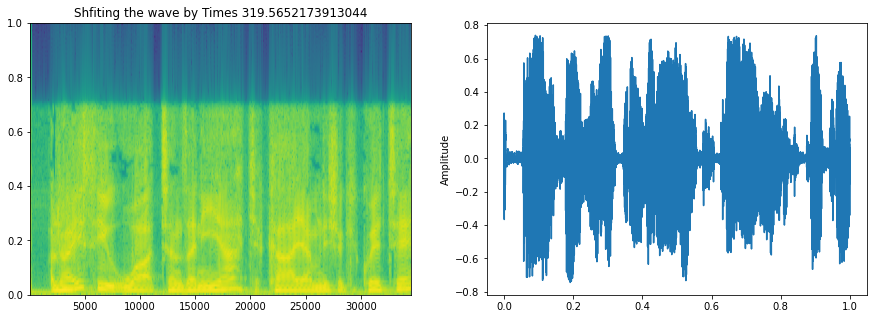

In [18]:
wav_roll = np.roll(samples,int(sample_rate/x))
plot_spec(data=wav_roll,sr=sample_rate)
ipd.Audio(wav_roll,rate=sample_rate)

# Acoustic Modelling #

In [19]:
def model_1(input_dim, units, activation, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # TODO: Add batch normalization 
    bn_rnn = BatchNormalization()(simp_rnn)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    plot_model(model, to_file='models/model_1.png')
    return model